In [1]:

import matplotlib.pyplot as plt
import contextily as ctx


from io import BytesIO, StringIO
from owslib.wfs import WebFeatureService
from shapely.geometry import box
import geopandas as gpd
import requests
import pandas as pd
import pandas as pd
import geopandas as gpd
import requests
from io import StringIO
import requests
import json
import os

import boto3
import duckdb


import matplotlib.pyplot as plt

import numpy as np
import s2sphere
from botocore.config import Config
from rasterstats import zonal_stats
import matplotlib.pyplot as plt
import rasterstats
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from rasterio.features import rasterize
import numpy as np


import rioxarray
from shapely.geometry import box
from shapely.geometry import box


USE_CRS = "EPSG:5349"


# Generic mapping functions
def setup_base_map(figsize=(12, 10), bounds=None, padding_x=500, padding_y=500):
    """Create figure and set up basic map boundaries with padding."""
    if bounds is None:
        bounds = renabap_pba_intersect.total_bounds

    # Convert bounds to Web Mercator for basemap compatibility
    if bounds is not None:
        # Create a temporary GeoDataFrame with the bounds to reproject
        temp_bounds = gpd.GeoDataFrame(
            geometry=[box(bounds[0], bounds[1], bounds[2], bounds[3])], crs=USE_CRS
        )
        bounds_3857 = temp_bounds.to_crs("EPSG:3857").total_bounds
    else:
        bounds_3857 = bounds

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(bounds_3857[0] - padding_x, bounds_3857[2] + padding_x)
    ax.set_ylim(bounds_3857[1] - padding_y, bounds_3857[3] + padding_y)
    return fig, ax


def add_basemap(ax, zoom=13):
    """Add CartoDB basemap to the axes."""
    # The axes are already in Web Mercator from setup_base_map
    ctx.add_basemap(
        ax,
        source=ctx.providers.CartoDB.PositronNoLabels,
        zorder=0,
        zoom=zoom,
    )

    return ax


def add_north_arrow(ax, x=0.95, y=0.05, arrow_length=0.04):
    """Add a north arrow to the map."""
    # Add north arrow, https://stackoverflow.com/a/58110049/604456
    ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
                arrowprops=dict(facecolor='black', width=3, headwidth=10),
                ha='center', va='center', fontsize=14,
                xycoords=ax.transAxes)


def add_la_plata_outline(ax):
    """Add the outline of Partido de La Plata to a map."""
    la_plata_3857 = la_plata.to_crs("EPSG:3857")
    la_plata_3857.plot(
        ax=ax,
        facecolor='none',
        edgecolor='black',
        linewidth=0.5,
        linestyle='--',
        legend=False,
        zorder=5
    )

def create_consistent_map(title, bounds=None):
    """Create a map with consistent styling and basemap."""
    fig, ax = setup_base_map(bounds=bounds)

    # Add basemap
    add_basemap(ax)

    # Add north arrow
    add_north_arrow(ax)

    # Add La Plata partido outline
    add_la_plata_outline(ax)

    # Set title
    ax.set_title(title, fontsize=16, fontweight="bold", pad=20)

    # Remove axes
    ax.set_axis_off()

    return fig, ax



def wfs_to_gdf(
    wfs_url: str, layer_name: str, srs: str = "EPSG:4326"
) -> gpd.GeoDataFrame:
    """
    Descarga una capa WFS y la devuelve como GeoDataFrame.

    Args:
        wfs_url (str): URL del servicio WFS.
        layer_name (str): Nombre de la capa (typename).
        srs (str): Código EPSG del sistema de referencia de coordenadas.

    Returns:
        gpd.GeoDataFrame: Capa descargada como GeoDataFrame.
    """
    wfs = WebFeatureService(url=wfs_url, version="2.0.0")
    response = wfs.getfeature(typename=layer_name, srsname=srs)
    gdf = gpd.read_file(BytesIO(response.read()))
    return gdf


In [2]:
response = requests.get(
    "https://www.argentina.gob.ar/sites/default/files/renabap-2023-12-06.geojson"
)
renabap = gpd.read_file(StringIO(response.text))
renabap_pba = renabap[renabap["provincia"] == "Buenos Aires"]
renabap_pba = renabap_pba.to_crs(USE_CRS)

In [3]:
peligro_path = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/data/la_plata_pelig_2023_datos_originales.geojson"
peligro = gpd.read_file(peligro_path)
peligro = peligro.to_crs(USE_CRS)

peligro_bounds = peligro.total_bounds
peligro_bbox = box(*peligro_bounds)

In [4]:
# Try to read from local file first, then fetch from WFS if needed
partidos_file_path = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/data/pba_partidos.geojson"

if os.path.exists(partidos_file_path):
    partidos = gpd.read_file(partidos_file_path)
else:
    partidos = wfs_to_gdf(
        wfs_url="https://geo.arba.gov.ar/geoserver/idera/wfs",
        layer_name="idera:Departamento",
        srs="EPSG:5347",
    )
    
    # Save for future use
    partidos.to_file(partidos_file_path, driver="GeoJSON")

partidos = partidos.to_crs(USE_CRS)
la_plata = partidos[partidos["fna"] == "Partido de La Plata"]

In [5]:
# Obtener la geometría principal
main_geom = la_plata.geometry.iloc[0]

# Si es un MultiPolygon, mantener solo el polígono más grande (el partido principal)
# Esto elimina la pequeña isla que aparece en los datos
if main_geom.geom_type == 'MultiPolygon':
    # Obtener todos los polígonos y mantener el que tenga mayor área
    largest_polygon = max(main_geom.geoms, key=lambda p: p.area)
    la_plata = la_plata.copy()  # Create a copy to avoid SettingWithCopyWarning
    la_plata.loc[la_plata.index[0], 'geometry'] = largest_polygon

la_plata_bbox = la_plata.geometry.iloc[0]

renabap_pba_intersect = renabap_pba[
    renabap_pba.geometry.intersects(la_plata_bbox)
].copy()

In [6]:
# Try to read from local file first, then fetch from API if needed
cuencas_file_path = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/cuencas_buenos_aires.geojson"

if os.path.exists(cuencas_file_path):
    cuencas = gpd.read_file(cuencas_file_path)
else:
    cuencas_url = "https://services1.arcgis.com/atxllciEI8CHWvwW/ArcGIS/rest/services/Cuencas_BuenosAires_2023/FeatureServer/0/query"
    params = {
        'where': '1=1',
        'outFields': '*',
        'f': 'geojson'
    }
    
    cuencas_response = requests.get(cuencas_url, params=params)
    with open(cuencas_file_path, 'w', encoding='utf-8') as f:
        f.write(cuencas_response.text)
    
    cuencas = gpd.read_file(StringIO(cuencas_response.text))

cuencas = cuencas.to_crs(USE_CRS)
cuencas = cuencas.clip(la_plata)

eje_mapping = {
    'noreste': ['Area de Bañados', 'Cuenca Arroyo Rodriguez-Don Carlos'],
    'noroeste': ['Cuenca Arroyo Martín-Carnaval', 'Cuenca Arroyo Pereyra'],
    'central': ['Cuenca Arroyo del Gato'],
    'sudoeste': ['Cuenca A° Maldonado', 'Cuenca Río Samborombón'],
    'sudeste': ['Cuenca Arroyo El Pescado']
}

# Map watershed names to axes based on the eje_mapping
cuencas['eje'] = cuencas['Cuenca'].map(
    {cuenca: eje for eje, cuencas_list in eje_mapping.items() for cuenca in cuencas_list}
).fillna('otro')


In [7]:
# Calculate total area of RENABAP settlements in hectares (POSGAR projection is in meters)
renabap_total_area_ha = renabap_pba_intersect.geometry.area.sum() / 10000  # Convert m² to hectares
la_plata_area_ha = la_plata.geometry.iloc[0].area / 10000 
percentage_coverage = (renabap_total_area_ha / la_plata_area_ha) * 100

# Get common bounds for all maps
common_bounds = la_plata.total_bounds

# Intersect settlements with hazard zones
settlement_hazard = gpd.overlay(renabap_pba_intersect, peligro, how="intersection")

settle_hazard_cuencas = gpd.overlay(settlement_hazard, cuencas, how="intersection", keep_geom_type=True)

In [ ]:
fig1, ax1 = create_consistent_map("Asentamientos RENABAP en La Plata", common_bounds)

# Add RENABAP settlements as black outline with no fill
# Reproject to Web Mercator to match the map's coordinate system
renabap_pba_intersect_3857 = renabap_pba_intersect.to_crs("EPSG:3857")

renabap_pba_intersect_3857.plot(
    ax=ax1,
    facecolor='none',
    edgecolor='black',
    linewidth=0.5,
    legend=False,
    zorder=10
)

plt.tight_layout()
plt.show()

In [ ]:

peligro_clipped = gpd.clip(peligro, la_plata)

# Reproject to EPSG:3857 for web mapping
peligro_clipped_3857 = peligro_clipped.to_crs("EPSG:3857")

# Reorder the categories so they map correctly to plasma colormap
peligro_clipped_3857['PELIGROSID_ordered'] = pd.Categorical(
    peligro_clipped_3857['PELIGROSID'], 
    categories=['baja', 'media', 'alta'], 
    ordered=True
)

# Create map with plasma colormap
fig2, ax2 = create_consistent_map("Zonas de Peligro en La Plata", common_bounds)

# Plot with plasma colormap
peligro_clipped_3857.plot(
    ax=ax2,
    column="PELIGROSID_ordered",
    cmap='plasma',
    alpha=0.75,
    legend=True,
    zorder=5
)

plt.tight_layout()
plt.show()

In [8]:
import rioxarray
from shapely.geometry import box

# Load GHSL data with dask chunking for memory efficiency
ghsl = rioxarray.open_rasterio(
    "/home/nissim/Downloads/spatial/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13/GHS_POP_E2025_GLOBE_R2023A_54009_100_V1_0_R14_C13.tif",
    chunks={"x": 1024, "y": 1024},  # Adjust chunk size based on your memory constraints
)

# Reproject to your target CRS with streaming
ghsl = ghsl.rio.reproject(dst_crs=USE_CRS)

# Clip GHSL data to ONLY the Partido de La Plata boundaries
# This will remove any GHSL data outside the partido
ghsl_clipped = ghsl.rio.clip(
    [la_plata.geometry.iloc[0]],  # Use the actual La Plata partido geometry
    from_disk=True,  # Process from disk to avoid loading entire dataset into memory
)

KeyboardInterrupt: 

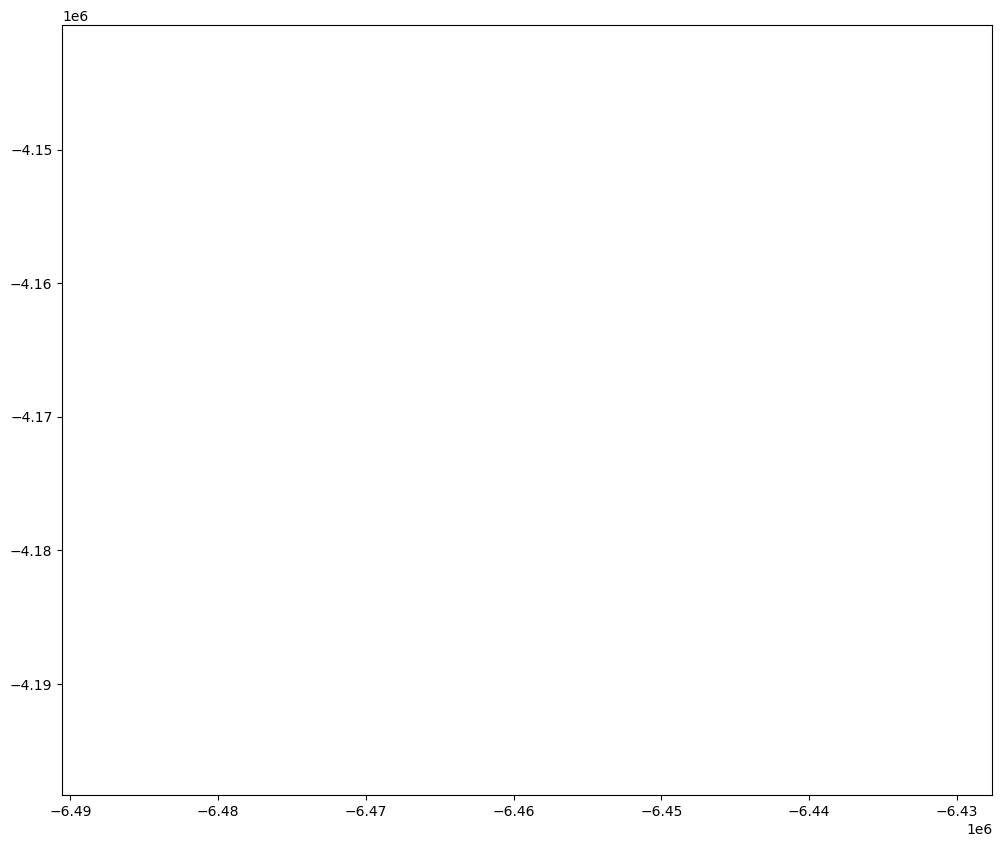

In [9]:
# Map 2: GHSL population data
fig2, ax2 = create_consistent_map("Datos de población GHSL", common_bounds)

# Create masked array to hide zero values (do this before jenks classification)
import numpy.ma as ma
ghsl_masked = ma.masked_where(ghsl_clipped.values[0] == 0, ghsl_clipped.values[0])

# Use continuous log scale for GHSL data (excluding nodata values and zeros)
ghsl_valid = (ghsl_clipped.values[0] != -200) & (ghsl_clipped.values[0] != 0)
ghsl_valid_data = ghsl_clipped.values[0][ghsl_valid]

plasma_cmap = plt.cm.plasma

# Reproject GHSL data to Web Mercator to match the map's coordinate system
ghsl_clipped_3857 = ghsl_clipped.rio.reproject("EPSG:3857")

# Mask out zeros AND nodata values
ghsl_masked_3857 = ma.masked_where(
    (ghsl_clipped_3857.values[0] == 0) | (ghsl_clipped_3857.values[0] == -200),
    ghsl_clipped_3857.values[0]
)

# Plot GHSL raster with continuous log scale and zero masking
# Use power normalization to emphasize distinctions without extreme compression
im = ax2.imshow(
    ghsl_masked_3857,
    extent=[ghsl_clipped_3857.x.min(), ghsl_clipped_3857.x.max(), 
            ghsl_clipped_3857.y.min(), ghsl_clipped_3857.y.max()],
    cmap=plasma_cmap,
    alpha=0.75
)

plt.tight_layout()
plt.show()

In [10]:
def fetch_buildings(geodataframe, temp_file="buildings_filtered.parquet"):
    """Fetch building data for a given GeoDataFrame region"""

    # Get S2 cell and bounds
    center = geodataframe.to_crs("epsg:3857").union_all().centroid
    center_wgs84 = (
        gpd.GeoDataFrame(geometry=[center], crs="EPSG:3857")
        .to_crs(epsg=4326)
        .geometry.iloc[0]
    )
    cell = s2sphere.CellId.from_lat_lng(
        s2sphere.LatLng.from_degrees(center_wgs84.y, center_wgs84.x)
    ).parent(10)
    bounds = geodataframe.to_crs("epsg:4326").total_bounds

    # Find matching S2 partition
    s3 = boto3.client(
        "s3",
        endpoint_url="https://data.source.coop",
        aws_access_key_id="",
        aws_secret_access_key="",
        config=Config(s3={"addressing_style": "path"}),
    )

    partitions = {
        obj["Key"].split("/")[-1].replace(".parquet", "")
        for obj in s3.list_objects_v2(
            Bucket="vida",
            Prefix="google-microsoft-osm-open-buildings/geoparquet/by_country_s2/country_iso=ARG/",
        ).get("Contents", [])
    }

    parent_id = next(
        str(cell.parent(level).id())
        for level in range(10, 0, -1)
        if str(cell.parent(level).id()) in partitions
    )

    # Setup DuckDB and query
    con = duckdb.connect()
    for cmd in [
        "INSTALL spatial",
        "LOAD spatial",
        "INSTALL httpfs",
        "LOAD httpfs",
        "SET s3_region='us-east-1'",
        "SET s3_endpoint='data.source.coop'",
        "SET s3_use_ssl=true",
        "SET s3_url_style='path'",
    ]:
        con.execute(cmd)

    # Export and read back
    query = f"""
    COPY (SELECT * FROM 's3://vida/google-microsoft-osm-open-buildings/geoparquet/by_country_s2/country_iso=ARG/{parent_id}.parquet'
          WHERE bbox.xmax >= {bounds[0]} AND bbox.xmin <= {bounds[2]} AND
                bbox.ymax >= {bounds[1]} AND bbox.ymin <= {bounds[3]}
    ) TO '{temp_file}' (FORMAT PARQUET);
    """

    con.execute(query)
    df = pd.read_parquet(temp_file)
    df["geometry"] = gpd.GeoSeries.from_wkb(df["geometry"])

    return gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")


# Usage:
# Check if buildings file already exists, otherwise fetch from source
buildings_file = "/home/nissim/Documents/dev/fulbright/ciut-riesgo/notebooks/buildings_filtered.parquet"

if os.path.exists(buildings_file):
    buildings = gpd.read_parquet(buildings_file)
else:
    buildings = fetch_buildings(renabap_pba_intersect)

# Reproject buildings to match the analysis CRS
buildings_proj = buildings.to_crs(USE_CRS)

# clip the buildings to the partido de la plata
buildings_proj = buildings_proj.clip(la_plata)

In [ ]:
fig3, ax3 = create_consistent_map("Huellas de edificios", common_bounds)

buildings_3857 = buildings_proj.to_crs("EPSG:3857")

buildings_3857.plot(
    ax=ax3,
    facecolor='grey',
    edgecolor='none',
    alpha=0.7
)

plt.tight_layout()
plt.show()

## Areal

In [11]:
if renabap_pba_intersect.crs != peligro.crs:
    peligro = peligro.to_crs(renabap_pba_intersect.crs)

hazard_levels = peligro["PELIGROSID"].unique()

# 1. BARRIO AREAL EXPOSURE
renabap_with_porciones = renabap_pba_intersect.copy()
for level in hazard_levels:
    renabap_with_porciones[f"porcion_{level}"] = 0.0

renabap_with_porciones['total_area'] = renabap_with_porciones.geometry.area

for idx, barrio in renabap_with_porciones.iterrows():
    barrio_geom = barrio.geometry
    barrio_total_area = barrio_geom.area
    
    if barrio_total_area == 0:
        continue
        
    for level in hazard_levels:
        hazard_subset = peligro[peligro["PELIGROSID"] == level]
        
        if hazard_subset.empty:
            continue
        
        intersection_area = 0
        for _, hazard_row in hazard_subset.iterrows():
            try:
                intersection = barrio_geom.intersection(hazard_row.geometry)
                if not intersection.is_empty:
                    intersection_area += intersection.area
            except Exception as e:
                print(f"Error calculating intersection for {barrio.get('nombre_barrio', idx)}: {e}")
                continue
        
        proportion = intersection_area / barrio_total_area if barrio_total_area > 0 else 0
        renabap_with_porciones.at[idx, f"porcion_{level}"] = proportion

# Create barrio tidy format - only include hazard exposures > 0
barrio_areal_tidy = []
for idx, row in renabap_with_porciones.iterrows():
    # Add hazard exposures only if > 0
    for level in hazard_levels:
        familias_expuestas = row[f"porcion_{level}"] * row["familias_aproximadas"]
        if familias_expuestas > 0:
            barrio_areal_tidy.append({
                "id_renabap": row["id_renabap"],
                "peligrosidad": level,
                "fam_expuestas_areal": familias_expuestas
            })

barrio_areal_tidy = pd.DataFrame(barrio_areal_tidy)

# 2. CUENCA AREAL EXPOSURE - aggregate from barrio level, avoiding double counting
# Get the cuenca for each settlement - but handle settlements that cross cuenca boundaries
settlement_cuenca_mapping = settle_hazard_cuencas[['id_renabap', 'Cuenca']].drop_duplicates()

# Check if any settlements appear in multiple cuencas
settlement_counts = settlement_cuenca_mapping['id_renabap'].value_counts()
multi_cuenca_settlements = settlement_counts[settlement_counts > 1].index

if len(multi_cuenca_settlements) > 0:
    print(f"Warning: {len(multi_cuenca_settlements)} settlements appear in multiple cuencas")
    # For settlements in multiple cuencas, assign to the cuenca with largest intersection
    # For now, just take the first occurrence
    settlement_cuenca_mapping = settlement_cuenca_mapping.drop_duplicates(subset=['id_renabap'], keep='first')

cuenca_areal_tidy = barrio_areal_tidy[barrio_areal_tidy['peligrosidad'] != 'none'].merge(
    settlement_cuenca_mapping, on='id_renabap', how='left'
)
cuenca_areal_tidy = (
    cuenca_areal_tidy.groupby(['Cuenca', 'peligrosidad'])['fam_expuestas_areal']
    .sum()
    .reset_index()
)

# 3. EJE AREAL EXPOSURE - same fix
cuenca_eje_mapping = settle_hazard_cuencas[['Cuenca', 'eje']].drop_duplicates()

eje_areal_tidy = cuenca_areal_tidy.merge(cuenca_eje_mapping, on='Cuenca')
eje_areal_tidy = (
    eje_areal_tidy.groupby(['eje', 'peligrosidad'])['fam_expuestas_areal']
    .sum()
    .reset_index()
)

## Buildings

In [20]:
# Get ALL buildings per settlement (not just hazard-intersected ones)
buildings_settlement = gpd.overlay(buildings_proj, renabap_pba_intersect, how="intersection")
total_buildings_per_settlement = buildings_settlement.groupby('id_renabap').size().reset_index(name='total_buildings')

# Get buildings intersected with hazard zones
buildings_hazard = gpd.overlay(buildings_proj, settle_hazard_cuencas, how="intersection")

# 1. Buildings per barrio-hazard (including non-hazard areas)
buildings_barrio_hazard = buildings_hazard.groupby(['id_renabap', 'PELIGROSID']).size().reset_index(name='buildings_count')

# Calculate ratios using TOTAL buildings per settlement (not just hazard buildings)
barrio_ratios = buildings_barrio_hazard.merge(total_buildings_per_settlement, on='id_renabap')
barrio_ratios['ratio'] = barrio_ratios['buildings_count'] / barrio_ratios['total_buildings']
barrio_pop = renabap_pba_intersect[['id_renabap', 'familias_aproximadas']].drop_duplicates()
barrio_exposure = barrio_ratios.merge(barrio_pop, on='id_renabap')
barrio_exposure['fam_expuestas'] = barrio_exposure['ratio'] * barrio_exposure['familias_aproximadas']

# Add non-hazard population for each settlement
settlements_with_hazards = barrio_exposure['id_renabap'].unique()
all_settlements = total_buildings_per_settlement['id_renabap'].unique()

for settlement in all_settlements:
    if settlement in settlements_with_hazards:
        # Calculate non-hazard population
        hazard_pop = barrio_exposure[barrio_exposure['id_renabap'] == settlement]['fam_expuestas'].sum()
        total_pop = barrio_pop[barrio_pop['id_renabap'] == settlement]['familias_aproximadas'].iloc[0]
        non_hazard_pop = total_pop - hazard_pop
        
        if non_hazard_pop > 0:
            barrio_exposure = pd.concat([barrio_exposure, pd.DataFrame([{
                'id_renabap': settlement,
                'PELIGROSID': 'none',
                'buildings_count': 0,
                'total_buildings': total_buildings_per_settlement[total_buildings_per_settlement['id_renabap'] == settlement]['total_buildings'].iloc[0],
                'ratio': (total_buildings_per_settlement[total_buildings_per_settlement['id_renabap'] == settlement]['total_buildings'].iloc[0] - buildings_hazard[buildings_hazard['id_renabap'] == settlement].shape[0]) / total_buildings_per_settlement[total_buildings_per_settlement['id_renabap'] == settlement]['total_buildings'].iloc[0] if total_buildings_per_settlement[total_buildings_per_settlement['id_renabap'] == settlement]['total_buildings'].iloc[0] > 0 else 0,
                'familias_aproximadas': total_pop,
                'fam_expuestas': non_hazard_pop
            }])], ignore_index=True)
    else:
        # Settlement with no hazard intersection - all population is non-hazard
        total_pop = barrio_pop[barrio_pop['id_renabap'] == settlement]['familias_aproximadas'].iloc[0]
        barrio_exposure = pd.concat([barrio_exposure, pd.DataFrame([{
            'id_renabap': settlement,
            'PELIGROSID': 'none',
            'buildings_count': 0,
            'total_buildings': total_buildings_per_settlement[total_buildings_per_settlement['id_renabap'] == settlement]['total_buildings'].iloc[0],
            'ratio': 1.0,
            'familias_aproximadas': total_pop,
            'fam_expuestas': total_pop
        }])], ignore_index=True)

# Create buildings tidy dataframe for barrio level
buildings_barrio_tidy = barrio_exposure[['id_renabap', 'PELIGROSID', 'fam_expuestas']].copy()
buildings_barrio_tidy = buildings_barrio_tidy.rename(columns={'PELIGROSID': 'peligrosidad', 'fam_expuestas': 'fam_expuestas_buildings'})

# 2. Cuenca exposure - using total buildings across all settlements in cuenca
buildings_cuenca_hazard = buildings_hazard.groupby(['Cuenca', 'PELIGROSID']).size().reset_index(name='buildings_count')
buildings_cuenca_total = buildings_settlement.merge(
    settle_hazard_cuencas[['id_renabap', 'Cuenca']].drop_duplicates(), 
    on='id_renabap'
).groupby('Cuenca').size().reset_index(name='total_buildings_all')

cuenca_ratios = buildings_cuenca_hazard.merge(buildings_cuenca_total, on='Cuenca')
cuenca_ratios['ratio'] = cuenca_ratios['buildings_count'] / cuenca_ratios['total_buildings_all']

cuenca_pop = settle_hazard_cuencas.drop_duplicates('id_renabap').groupby('Cuenca')['familias_aproximadas'].sum().reset_index()
cuenca_exposure = cuenca_ratios.merge(cuenca_pop, on='Cuenca')
cuenca_exposure['fam_expuestas'] = cuenca_exposure['ratio'] * cuenca_exposure['familias_aproximadas']

# Create buildings tidy dataframe for cuenca level
buildings_cuenca_tidy = cuenca_exposure[['Cuenca', 'PELIGROSID', 'fam_expuestas']].copy()
buildings_cuenca_tidy = buildings_cuenca_tidy.rename(columns={'PELIGROSID': 'peligrosidad', 'fam_expuestas': 'fam_expuestas_buildings'})

# 3. Eje exposure - using total buildings across all settlements in eje
buildings_eje_hazard = buildings_hazard.groupby(['eje', 'PELIGROSID']).size().reset_index(name='buildings_count')
buildings_eje_total = buildings_settlement.merge(
    settle_hazard_cuencas[['id_renabap', 'eje']].drop_duplicates(), 
    on='id_renabap'
).groupby('eje').size().reset_index(name='total_buildings_all')

eje_ratios = buildings_eje_hazard.merge(buildings_eje_total, on='eje')
eje_ratios['ratio'] = eje_ratios['buildings_count'] / eje_ratios['total_buildings_all']

eje_pop = settle_hazard_cuencas.drop_duplicates('id_renabap').groupby('eje')['familias_aproximadas'].sum().reset_index()
eje_exposure = eje_ratios.merge(eje_pop, on='eje')
eje_exposure['fam_expuestas'] = eje_exposure['ratio'] * eje_exposure['familias_aproximadas']

# Create buildings tidy dataframe for eje level
buildings_eje_tidy = eje_exposure[['eje', 'PELIGROSID', 'fam_expuestas']].copy()
buildings_eje_tidy = buildings_eje_tidy.rename(columns={'PELIGROSID': 'peligrosidad', 'fam_expuestas': 'fam_expuestas_buildings'})

## GHSL

In [19]:

import rasterstats

# Step 1: Calculate the total GHSL population per barrio popular using zonal statistics

# Convert to the format expected by rasterstats
geometries = [geom for geom in renabap_pba_intersect.geometry]

# Use rasterstats for vectorized zonal statistics
stats = rasterstats.zonal_stats(
    geometries,
    ghsl_clipped.values[0],  # rasterstats expects 2D array
    affine=ghsl_clipped.rio.transform(),
    stats=["sum"],
    nodata=ghsl_clipped.rio.nodata,
)

# Extract the sum values
ghsl_totals = [stat["sum"] if stat["sum"] is not None else 0 for stat in stats]

# Add the GHSL population estimates as a new column
renabap_pba_intersect["ghsl_pop_est"] = ghsl_totals

from rasterio.features import rasterize
import numpy as np

# Get the reference raster properties from GHSL data
reference_raster = ghsl_clipped
reference_transform = reference_raster.rio.transform()
reference_crs = reference_raster.rio.crs
reference_shape = reference_raster.shape[1:]  # Get 2D shape (height, width)


# Prepare geometries and values for rasterization
geometries_ghsl = [
    (geom, value)
    for geom, value in zip(
        renabap_pba_intersect.geometry, renabap_pba_intersect["ghsl_pop_est"]
    )
]
geometries_familias = [
    (geom, value)
    for geom, value in zip(
        renabap_pba_intersect.geometry, renabap_pba_intersect["familias_aproximadas"]
    )
]

# Create GHSL population raster
ghsl_pop_raster = rasterize(
    geometries_ghsl,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=False,
)

# Create familias aproximadas raster
familias_raster = rasterize(
    geometries_familias,
    out_shape=reference_shape,
    transform=reference_transform,
    fill=0,
    dtype=np.float32,
    all_touched=False,
)


# Step 1: Divide original GHSL by the barrio-level GHSL to get fractional population
# Use masking to avoid division on invalid cells
mask = (ghsl_clipped.values[0] != -200) & (ghsl_pop_raster > 0.1)
ghsl_fractional = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
ghsl_fractional[mask] = ghsl_clipped.values[0][mask] / ghsl_pop_raster[mask]

# Step 2: Multiply fractional population by familias aproximadas to get downscaled data
mask2 = (ghsl_fractional != -200) & (familias_raster > 0)
familias_downscaled = np.full_like(ghsl_clipped.values[0], -200, dtype=np.float64)
familias_downscaled[mask2] = ghsl_fractional[mask2] * familias_raster[mask2]

# Verify the results - exclude -200 from range calculations
ghsl_valid = ghsl_clipped.values[0] != -200
fractional_valid = ghsl_fractional != -200
downscaled_valid = familias_downscaled != -200

# GHSL downscaling for all three levels using the same approach

# 1. BARRIO-HAZARD EXPOSURE (your existing approach)
ghsl_barrio_tidy = []
for idx, row in settlement_hazard.iterrows():
    stats = zonal_stats(
        [row.geometry],
        familias_downscaled,
        affine=reference_transform,
        stats=["sum"],
        nodata=-200,
    )[0]
    
    ghsl_barrio_tidy.append({
        "id_renabap": row["id_renabap"],
        "peligrosidad": row["PELIGROSID"],
        "fam_expuestas_ghsl": stats["sum"] if stats["sum"] is not None else 0,
    })

ghsl_barrio_tidy = pd.DataFrame(ghsl_barrio_tidy)

# 2. CUENCA-HAZARD EXPOSURE
ghsl_cuenca_tidy = []
for cuenca in settle_hazard_cuencas['Cuenca'].unique():
    for peligro in settle_hazard_cuencas['PELIGROSID'].unique():
        # Get all geometries for this cuenca-hazard combination
        geoms = settle_hazard_cuencas[
            (settle_hazard_cuencas['Cuenca'] == cuenca) & 
            (settle_hazard_cuencas['PELIGROSID'] == peligro)
        ].geometry.tolist()
        
        if geoms:
            stats = zonal_stats(
                geoms,
                familias_downscaled,
                affine=reference_transform,
                stats=["sum"],
                nodata=-200,
            )
            
            total_pop = sum([stat["sum"] if stat["sum"] is not None else 0 for stat in stats])
            
            ghsl_cuenca_tidy.append({
                "Cuenca": cuenca,
                "peligrosidad": peligro,
                "fam_expuestas_ghsl": total_pop,
            })

ghsl_cuenca_tidy = pd.DataFrame(ghsl_cuenca_tidy)

# 3. EJE-HAZARD EXPOSURE  
ghsl_eje_tidy = []
for eje in settle_hazard_cuencas['eje'].unique():
    for peligro in settle_hazard_cuencas['PELIGROSID'].unique():
        # Get all geometries for this eje-hazard combination
        geoms = settle_hazard_cuencas[
            (settle_hazard_cuencas['eje'] == eje) & 
            (settle_hazard_cuencas['PELIGROSID'] == peligro)
        ].geometry.tolist()
        
        if geoms:
            stats = zonal_stats(
                geoms,
                familias_downscaled,
                affine=reference_transform,
                stats=["sum"],
                nodata=-200,
            )
            
            total_pop = sum([stat["sum"] if stat["sum"] is not None else 0 for stat in stats])
            
            ghsl_eje_tidy.append({
                "eje": eje,
                "peligrosidad": peligro,
                "fam_expuestas_ghsl": total_pop,
            })

ghsl_eje_tidy = pd.DataFrame(ghsl_eje_tidy)

## Tidy

In [43]:
# 1. BARRIO-LEVEL WIDE DATAFRAME
renabap_info = renabap_pba_intersect[['id_renabap', 'nombre_barrio']].drop_duplicates()

barrio_wide = barrio_areal_tidy[barrio_areal_tidy['peligrosidad'] != 'none'].merge(
    ghsl_barrio_tidy[ghsl_barrio_tidy['peligrosidad'] != 'none'], on=['id_renabap', 'peligrosidad'], how='outer'
).merge(
    buildings_barrio_tidy[buildings_barrio_tidy['peligrosidad'] != 'none'].rename(columns={'fam_expuestas_buildings': 'fam_expuestas_edificios'}), 
    on=['id_renabap', 'peligrosidad'], how='outer'
).merge(
    renabap_info, on='id_renabap', how='left'
)

barrio_wide = barrio_wide[['id_renabap', 'nombre_barrio', 'peligrosidad', 
                          'fam_expuestas_edificios', 'fam_expuestas_ghsl', 'fam_expuestas_areal']]
barrio_wide = barrio_wide.fillna(0)

# 2. CUENCA-LEVEL WIDE DATAFRAME
settlement_cuenca_mapping = settle_hazard_cuencas[['id_renabap', 'Cuenca']].drop_duplicates()
settlement_counts = settlement_cuenca_mapping['id_renabap'].value_counts()
multi_cuenca_settlements = settlement_counts[settlement_counts > 1].index
if len(multi_cuenca_settlements) > 0:
    settlement_cuenca_mapping = settlement_cuenca_mapping.drop_duplicates(subset=['id_renabap'], keep='first')

cuenca_buildings_wide = buildings_barrio_tidy[buildings_barrio_tidy['peligrosidad'] != 'none'].merge(
    settlement_cuenca_mapping, on='id_renabap', how='left'
).groupby(['Cuenca', 'peligrosidad'])['fam_expuestas_buildings'].sum().reset_index()
cuenca_buildings_wide = cuenca_buildings_wide.rename(columns={'fam_expuestas_buildings': 'fam_expuestas_edificios'})

cuenca_wide = cuenca_areal_tidy[cuenca_areal_tidy['peligrosidad'] != 'none'].merge(
    ghsl_cuenca_tidy[ghsl_cuenca_tidy['peligrosidad'] != 'none'], on=['Cuenca', 'peligrosidad'], how='outer'
).merge(
    cuenca_buildings_wide, on=['Cuenca', 'peligrosidad'], how='outer'
)

cuenca_wide['cuenca'] = cuenca_wide['Cuenca'].str.lower()
cuenca_wide = cuenca_wide[['cuenca', 'peligrosidad', 
                          'fam_expuestas_edificios', 'fam_expuestas_ghsl', 'fam_expuestas_areal']]
cuenca_wide = cuenca_wide.fillna(0)

# 3. EJE-LEVEL WIDE DATAFRAME
settlement_eje_mapping = settle_hazard_cuencas[['id_renabap', 'eje']].drop_duplicates()
eje_settlement_counts = settlement_eje_mapping['id_renabap'].value_counts()
multi_eje_settlements = eje_settlement_counts[eje_settlement_counts > 1].index
if len(multi_eje_settlements) > 0:
    settlement_eje_mapping = settlement_eje_mapping.drop_duplicates(subset=['id_renabap'], keep='first')

eje_buildings_wide = buildings_barrio_tidy[buildings_barrio_tidy['peligrosidad'] != 'none'].merge(
    settlement_eje_mapping, on='id_renabap', how='left'
).groupby(['eje', 'peligrosidad'])['fam_expuestas_buildings'].sum().reset_index()
eje_buildings_wide = eje_buildings_wide.rename(columns={'fam_expuestas_buildings': 'fam_expuestas_edificios'})

eje_wide = eje_areal_tidy[eje_areal_tidy['peligrosidad'] != 'none'].merge(
    ghsl_eje_tidy[ghsl_eje_tidy['peligrosidad'] != 'none'], on=['eje', 'peligrosidad'], how='outer'
).merge(
    eje_buildings_wide, on=['eje', 'peligrosidad'], how='outer'
)

eje_wide = eje_wide[['eje', 'peligrosidad', 
                    'fam_expuestas_edificios', 'fam_expuestas_ghsl', 'fam_expuestas_areal']]
eje_wide = eje_wide.fillna(0)

In [44]:
from itables import show

show(cuenca_wide)

In [46]:
show(eje_wide)

## CONTINUE

In [53]:
# Create genuinely tidy version of barrio_wide
barrio_tidy = pd.melt(
    barrio_wide, 
    id_vars=['id_renabap', 'nombre_barrio', 'peligrosidad'],
    value_vars=['fam_expuestas_edificios', 'fam_expuestas_ghsl', 'fam_expuestas_areal'],
    var_name='metodo',
    value_name='fam_expuestas'
)

# Clean up method names
barrio_tidy['metodo'] = barrio_tidy['metodo'].str.replace('fam_expuestas_', '')

# Add geometry back
barrio_tidy = barrio_tidy.merge(
    renabap_pba_intersect[['id_renabap', 'geometry']], 
    on='id_renabap', 
    how='left'
)

# Calculate area
barrio_tidy['area'] = barrio_tidy.geometry.apply(lambda geom: geom.area)

In [54]:
barrio_tidy

id_renabap  nombre_barrio peligrosidad     metodo  fam_expuestas  \
0              2    Malvinas II         baja  edificios       3.538827   
1              3    Ferroviario         baja  edificios      33.654237   
2              3    Ferroviario        media  edificios      22.766102   
3              4    La Favelita         alta  edificios      36.258824   
4              4    La Favelita        media  edificios     122.964706   
...          ...            ...          ...        ...            ...   
1075        6542  Villa Montoro        media      areal       1.816473   
1076        6544    La Cerámica         alta      areal       1.071499   
1077        6544    La Cerámica         baja      areal       0.930977   
1078        6544    La Cerámica        media      areal       1.388593   
1079        6545   Los Zorzales         baja      areal       0.901255   

                                               geometry          area  
0     MULTIPOLYGON (((7133413.584 6125858.719, 71336...  98337.704269  
1     MULTIPOLYGON (((7127613.216 6115863.573, 71276...  76093.185423  
2     MULTIPOLYGON (((7127613.216 6115863.573, 71276...  76093.185423  
3     MULTIPOLYGON (((7136174.621 6130304.579, 71361...  36977.935167  
4     MULTIPOLYGON (((7136174.621 6130304.579, 71361...  36977.935167  
...                                                 ...           ...  
1075  MULTIPOLYGON (((7143819.73 6126788.913, 714373...  12479.145508  
1076  MULTIPOLYGON (((7122755.172 6133505.936, 71228...  45276.088363  
1077  MULTIPOLYGON (((7122755.172 6133505.936, 71228...  45276.088363  
1078  MULTIPOLYGON (((7122755.172 6133505.936, 71228...  45276.088363  
1079  MULTIPOLYGON (((7125256.804 6135240.007, 71253...   3389.911320  

[1080 rows x 7 columns]

In [55]:
# Group by id_renabap and peligro, then find which method has the highest fam_expuestas
highest_methods = barrio_tidy.groupby(['id_renabap', 'peligrosidad'])['fam_expuestas'].idxmax()

# Get the method names for the highest estimates
method_counts = barrio_tidy.loc[highest_methods, 'metodo'].value_counts()

# Display results
print("Method that most often returns highest fam_expuestas estimate:")
print(method_counts)

# Group by id_renabap and peligro, then find which method has the lowest fam_expuestas
lowest_methods = barrio_tidy.groupby(['id_renabap', 'peligrosidad'])['fam_expuestas'].idxmin()

# Get the method names for the lowest estimates
lowest_method_counts = barrio_tidy.loc[lowest_methods, 'metodo'].value_counts()

# Display results
print("Method that most often returns lowest fam_expuestas estimate:")
print(lowest_method_counts)

Method that most often returns highest fam_expuestas estimate:
metodo
edificios    209
areal         76
ghsl          68
Name: count, dtype: int64
Method that most often returns lowest fam_expuestas estimate:
metodo
ghsl         205
areal        108
edificios     40
Name: count, dtype: int64


In [50]:
# First, left join familias_aproximadas from renabap_pba_intersect
final_tidy_with_pop = barrio_tidy.merge(
    renabap_pba_intersect[['id_renabap', 'familias_aproximadas']], 
    on='id_renabap', 
    how='left'
)

# Calculate the range (highest - lowest) per id_renabap and peligro
range_by_barrio = final_tidy_with_pop.groupby(['id_renabap', 'peligrosidad'])['fam_expuestas'].agg(['max', 'min'])
range_by_barrio['range'] = range_by_barrio['max'] - range_by_barrio['min']

# Merge back to get the total population for each barrio
range_by_barrio = range_by_barrio.reset_index().merge(
    final_tidy_with_pop[['id_renabap', 'familias_aproximadas']].drop_duplicates(),
    on='id_renabap'
)

# Calculate absolute percent difference as fraction of total barrio population
range_by_barrio['abs_pct_diff'] = (range_by_barrio['range'] / range_by_barrio['familias_aproximadas']) * 100

# Calculate average absolute percent difference per peligro level
avg_pct_diff_by_peligro = range_by_barrio.groupby('peligrosidad')['abs_pct_diff'].mean()

print("Average absolute percent difference between highest and lowest estimates per peligro level:")
print(avg_pct_diff_by_peligro.round(2))

# Optional: Show the overall average across all peligro levels
print(f"\nOverall average: {range_by_barrio['abs_pct_diff'].mean():.2f}%")

Average absolute percent difference between highest and lowest estimates per peligro level:
peligrosidad
alta     13.78
baja     16.69
media    14.80
Name: abs_pct_diff, dtype: float64

Overall average: 15.38%


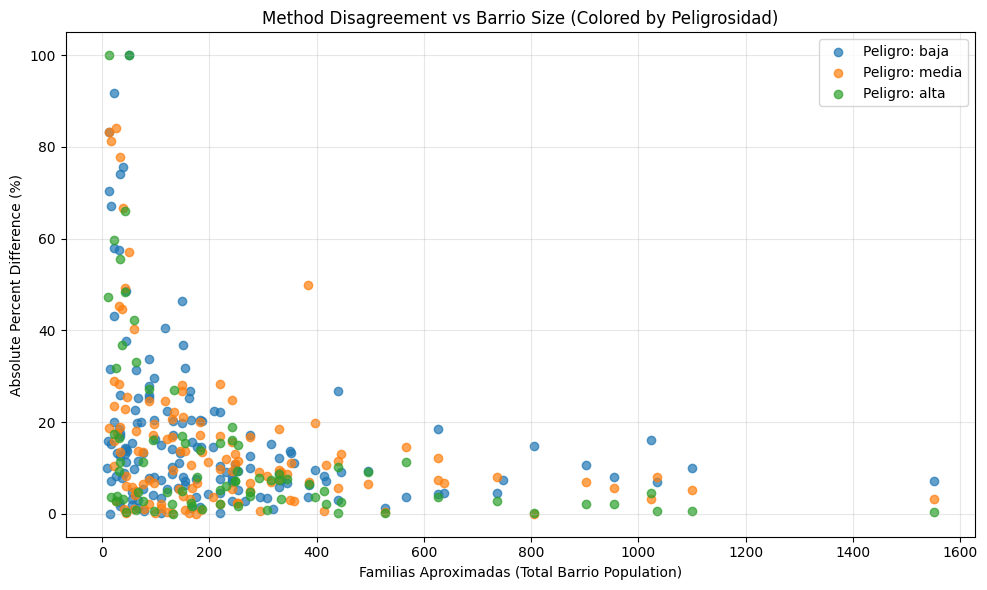

In [51]:
import matplotlib.pyplot as plt

# Create scatter plot colored by peligrosidad
plt.figure(figsize=(10, 6))

# Get unique peligrosidad levels
peligrosidad_levels = range_by_barrio['peligrosidad'].unique()

for peligro in peligrosidad_levels:
    # Filter data for this peligrosidad level
    peligro_data = range_by_barrio[range_by_barrio['peligrosidad'] == peligro]
    
    plt.scatter(peligro_data['familias_aproximadas'], 
                peligro_data['abs_pct_diff'], 
                alpha=0.7, 
                label=f'Peligro: {peligro}')

plt.xlabel('Familias Aproximadas (Total Barrio Population)')
plt.ylabel('Absolute Percent Difference (%)')
plt.title('Method Disagreement vs Barrio Size (Colored by Peligrosidad)')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

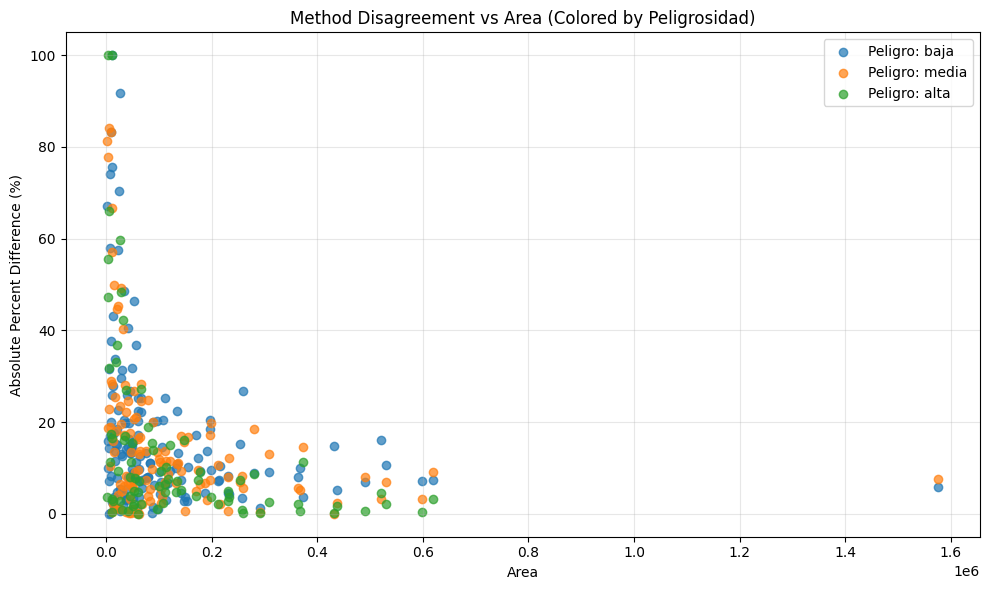

In [56]:
# First, get the area data from final_tidy
area_data = barrio_tidy[['id_renabap', 'area']].drop_duplicates()

# Merge area back into range_by_barrio
range_by_barrio_with_area = range_by_barrio.merge(area_data, on='id_renabap', how='left')

# Now create the scatter plot with area
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# Get unique peligrosidad levels
peligrosidad_levels = range_by_barrio_with_area['peligrosidad'].unique()

for peligro in peligrosidad_levels:
    # Filter data for this peligrosidad level
    peligro_data = range_by_barrio_with_area[range_by_barrio_with_area['peligrosidad'] == peligro]
    
    plt.scatter(peligro_data['area'], 
                peligro_data['abs_pct_diff'], 
                alpha=0.7, 
                label=f'Peligro: {peligro}')

plt.xlabel('Area')
plt.ylabel('Absolute Percent Difference (%)')
plt.title('Method Disagreement vs Area (Colored by Peligrosidad)')

plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

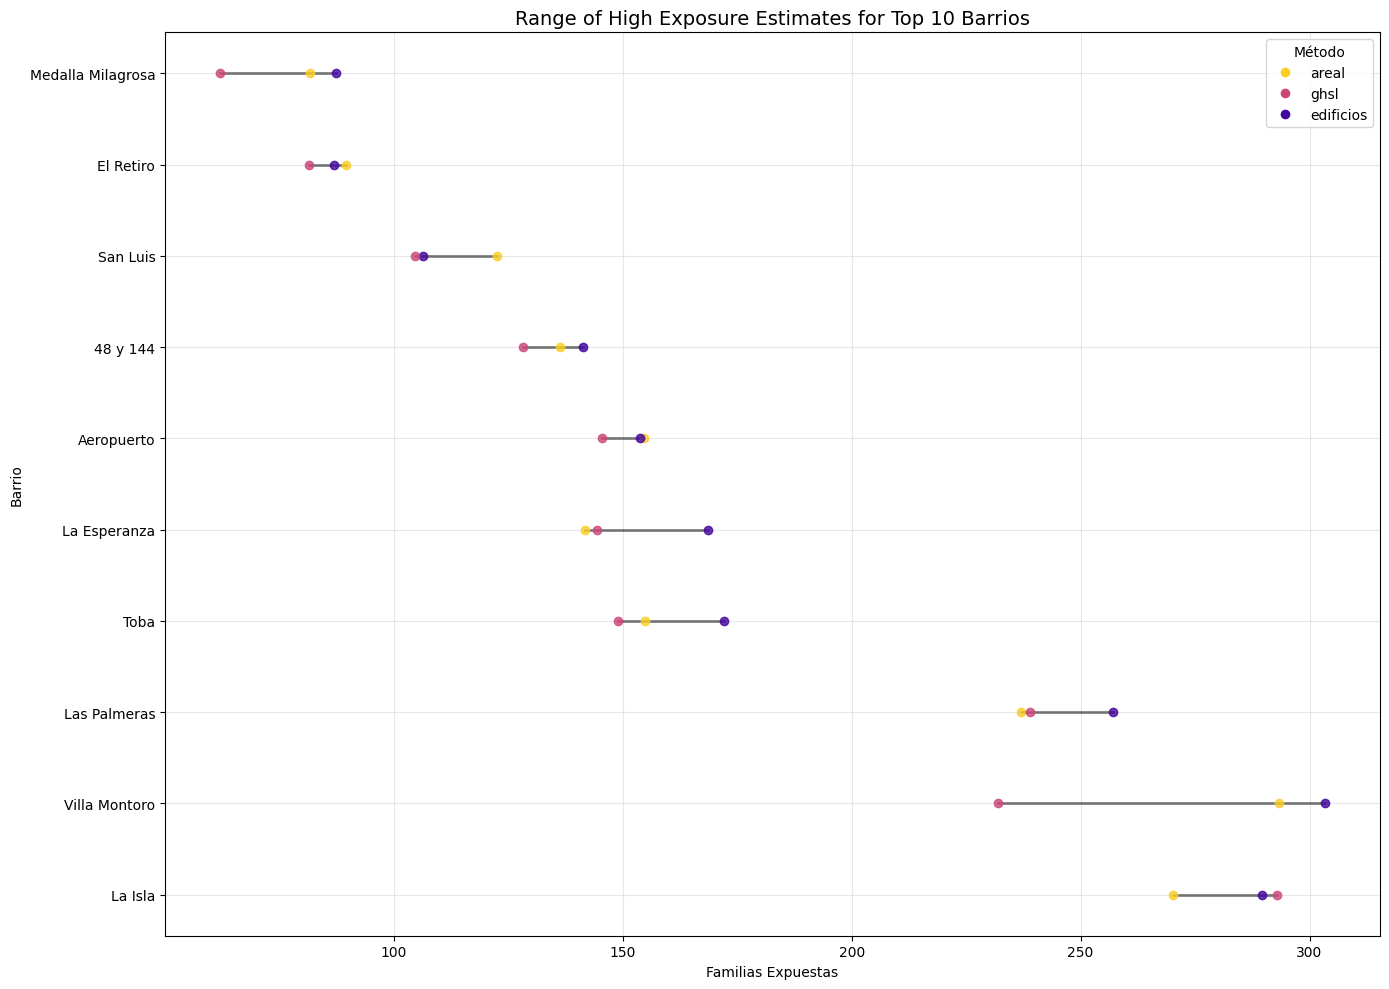

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

# Filter for high exposure (alta peligrosidad) using the joined dataframe
alta_data = barrio_tidy[barrio_tidy["peligrosidad"] == "alta"].copy()

# Aggregate by nombre_barrio and sum fam_expuestas for each method
# This handles cases where there are multiple geometries with the same barrio name
alta_aggregated = (
    alta_data.groupby(["nombre_barrio", "metodo"])["fam_expuestas"]
    .sum()
    .reset_index()
)

# Remove cases where the barrio name is "Sin Nombre"
alta_aggregated = alta_aggregated[alta_aggregated["nombre_barrio"] != "Sin Nombre"].copy()

# Calculate total exposure per barrio across all methods
total_exposure = (
    alta_aggregated.groupby("nombre_barrio")["fam_expuestas"]
    .sum()
    .sort_values(ascending=False)
)
top_10_barrios = total_exposure.head(10).index

# Filter aggregated data for top 10 barrios
top_10_data = alta_aggregated[
    alta_aggregated["nombre_barrio"].isin(top_10_barrios)
].copy()

# Create range plot showing min, max, and individual points
plt.figure(figsize=(14, 10))  # Increased height to accommodate longer barrio names


# Get RdPu colormap using the correct syntax
plasma_cmap = cm.plasma

# Define colors for peligrosidad levels using RdPu colormap
peligrosidad_colors = {
    "alta": plasma_cmap(0.8),    # Darker red-purple for high risk
    "media": plasma_cmap(0.5),    # Lighter red-purple for medium risk
    "baja": plasma_cmap(0.2)    # Lighter red-purple for medium risk
}

# Define colors for methods using categorical color scheme
method_colors = {
    "areal": plasma_cmap(0.9),
    "ghsl": plasma_cmap(0.5), 
    "edificios": plasma_cmap(0.1)
}

for i, barrio in enumerate(top_10_barrios):
    barrio_data = top_10_data[top_10_data["nombre_barrio"] == barrio]
    if len(barrio_data) > 0:
        values = barrio_data["fam_expuestas"].values
        min_val = values.min()
        max_val = values.max()

        # Plot range line
        plt.plot([min_val, max_val], [i, i], "k-", alpha=0.5, linewidth=2)

        # Plot individual points colored by method
        for _, row in barrio_data.iterrows():
            color = method_colors[row["metodo"]]
            plt.plot(row["fam_expuestas"], i, "o", color=color, markersize=6, alpha=0.8)

plt.yticks(range(len(top_10_barrios)), top_10_barrios)
plt.xlabel("Familias Expuestas")
plt.ylabel("Barrio")
plt.title("Range of High Exposure Estimates for Top 10 Barrios", fontsize=14)
plt.grid(True, alpha=0.3)

# Add legend
legend_elements = [
    plt.Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color,
        markersize=8,
        label=method,
    )
    for method, color in method_colors.items()
]
plt.legend(handles=legend_elements, title="Método")

plt.tight_layout()
plt.show()

In [60]:
area_data = barrio_tidy[barrio_tidy["metodo"] == "area"].groupby(["nombre_barrio", "peligrosidad"])["fam_expuestas"].sum().reset_index()
area_data = area_data.rename(columns={"fam_expuestas": "fam_expuestas_area"})

ghsl_data = barrio_tidy[barrio_tidy["metodo"] == "ghsl"].groupby(["nombre_barrio", "peligrosidad"])["fam_expuestas"].sum().reset_index()
ghsl_data = ghsl_data.rename(columns={"fam_expuestas": "fam_expuestas_ghsl"})

edificios_data = barrio_tidy[barrio_tidy["metodo"] == "edificios"].groupby(["nombre_barrio", "peligrosidad"])["fam_expuestas"].sum().reset_index()
edificios_data = edificios_data.rename(columns={"fam_expuestas": "fam_expuestas_edificios"})

# Merge all methods together
barrio_summary = area_data.merge(ghsl_data, on=["nombre_barrio", "peligrosidad"], how="outer")
barrio_summary = barrio_summary.merge(edificios_data, on=["nombre_barrio", "peligrosidad"], how="outer")

barrio_summary = barrio_summary.fillna(0)

from itables import show

# Sort by nombre_barrio and peligrosidad in descending order
barrio_summary = barrio_summary.sort_values(["nombre_barrio", "peligrosidad"], ascending=True)

show(barrio_summary)

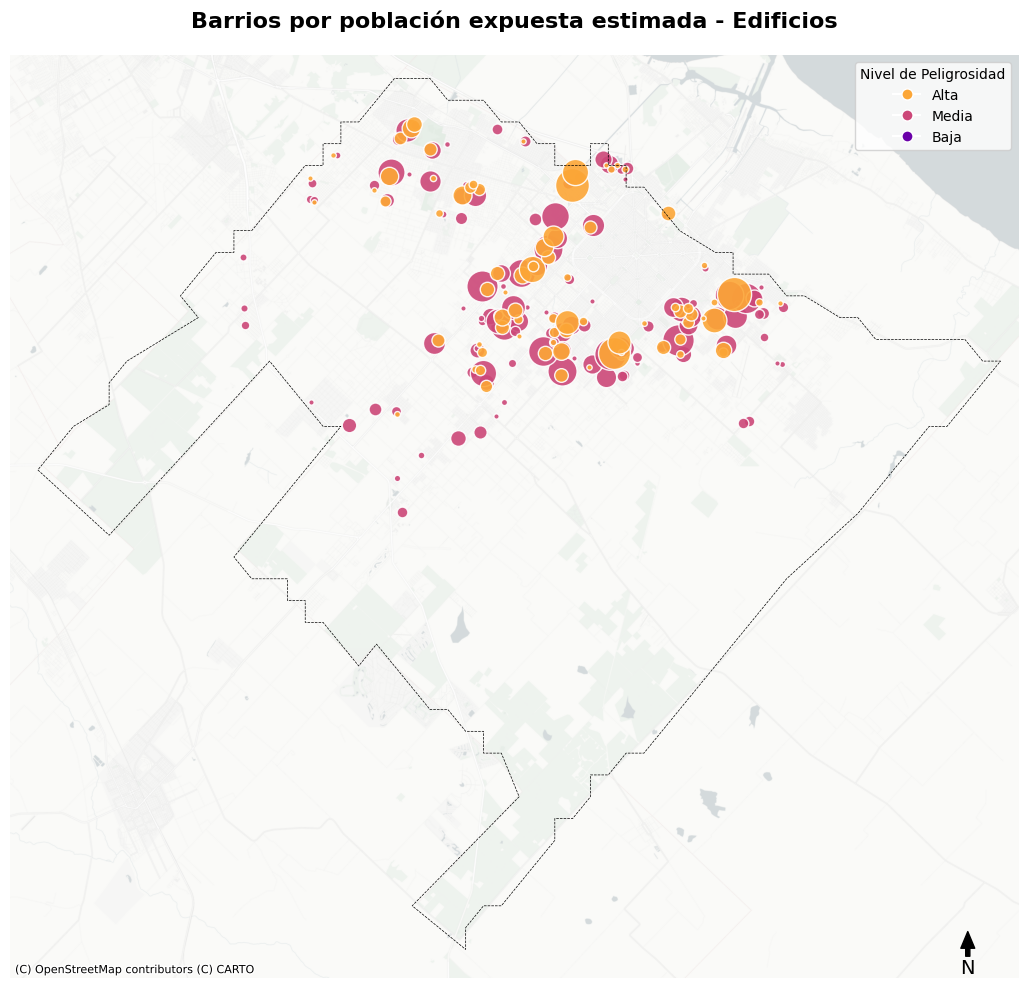

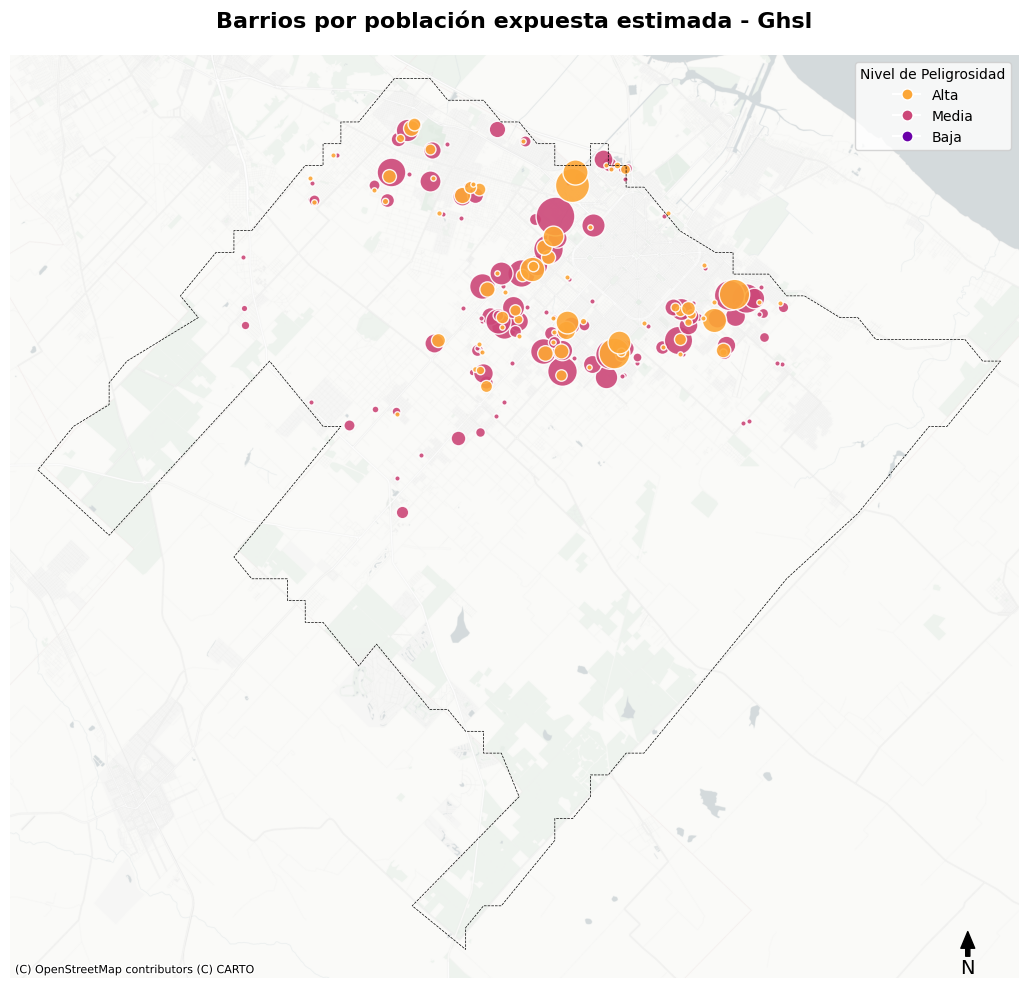

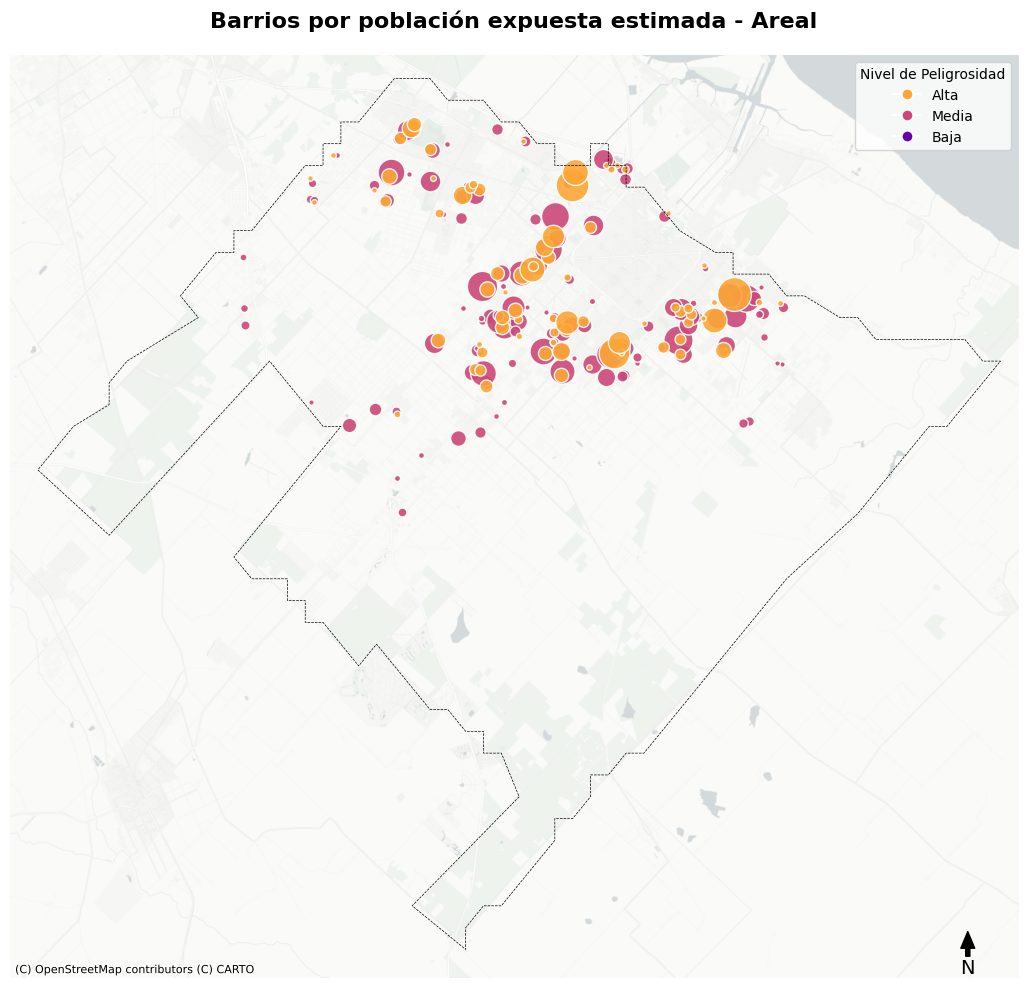

In [61]:
def plot_method_map(method_name, final_tidy, la_plata, peligrosidad_colors, common_bounds, create_consistent_map):
    fig, ax = create_consistent_map(f"Barrios por población expuesta estimada - {method_name.capitalize()}", common_bounds)
    
    method_data = final_tidy[
        (final_tidy["metodo"] == method_name) &
        (final_tidy["peligrosidad"].isin(["alta", "media"]))
    ].copy()
    
    method_gdf = gpd.GeoDataFrame(method_data, geometry='geometry', crs='EPSG:5349')
    method_gdf = method_gdf.clip(la_plata)
    method_gdf_3857 = method_gdf.to_crs('EPSG:3857')
    
    plotting_order = ["media", "alta"]
    
    np.random.seed(42)
    for peligrosidad in plotting_order:
        level_data = method_gdf_3857[method_gdf_3857["peligrosidad"] == peligrosidad]
        for _, row in level_data.iterrows():
            centroid = row["geometry"].centroid
            jitter_x = np.random.uniform(-200, 200)
            jitter_y = np.random.uniform(-200, 200)
            x_pos = centroid.x + jitter_x
            y_pos = centroid.y + jitter_y
            color = peligrosidad_colors[row["peligrosidad"]]
            size = max(10, row["fam_expuestas"] * 2 + 15)
            ax.scatter(
                x_pos, y_pos,
                s=size, color=color,
                alpha=0.9,
                edgecolors='white',
                linewidth=1.0
            )
    
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=level.capitalize())
        for level, color in peligrosidad_colors.items()
    ]
    ax.legend(handles=legend_elements, title="Nivel de Peligrosidad", loc='upper right')
    plt.tight_layout()
    plt.show()

methods = barrio_tidy["metodo"].unique()

for method in methods:
    plot_method_map(method, barrio_tidy, la_plata, peligrosidad_colors, common_bounds, create_consistent_map)

In [67]:
cuenca_tidy_gdf

cuenca peligrosidad     metodo  fam_expuestas Cuenca  \
0            area de bañados         alta  edificios     239.445786    NaN   
1            area de bañados         baja  edificios    1270.024898    NaN   
2            area de bañados        media  edificios     318.066471    NaN   
3   cuenca arroyo el pescado         baja  edificios      67.360825    NaN   
4   cuenca arroyo el pescado        media  edificios      22.453608    NaN   
..                       ...          ...        ...            ...    ...   
64       cuenca a° maldonado         baja      areal    2132.265732    NaN   
65       cuenca a° maldonado        media      areal    1453.435934    NaN   
66    cuenca río samborombón         alta      areal       4.489577    NaN   
67    cuenca río samborombón         baja      areal     226.552539    NaN   
68    cuenca río samborombón        media      areal     215.670182    NaN   

   geometry  
0      None  
1      None  
2      None  
3      None  
4      None  
..      ...  
64     None  
65     None  
66     None  
67     None  
68     None  

[69 rows x 6 columns]

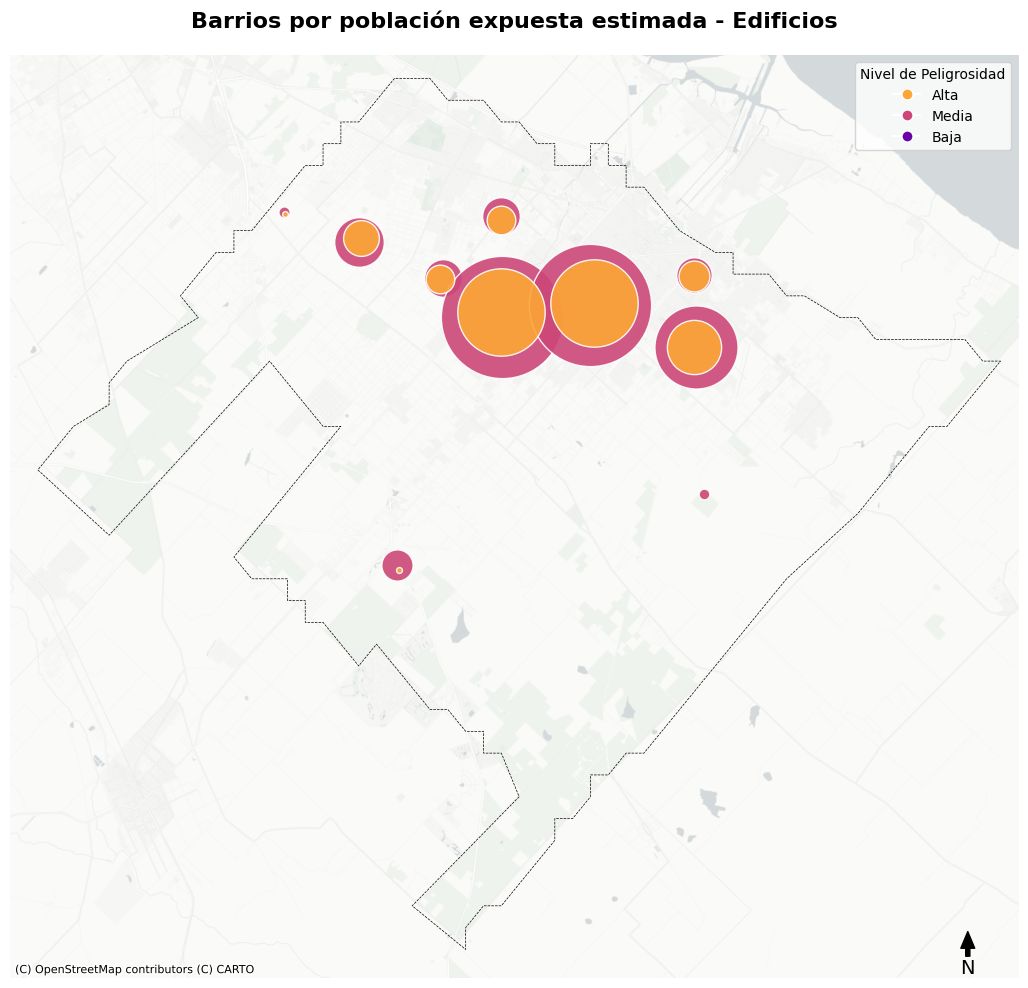

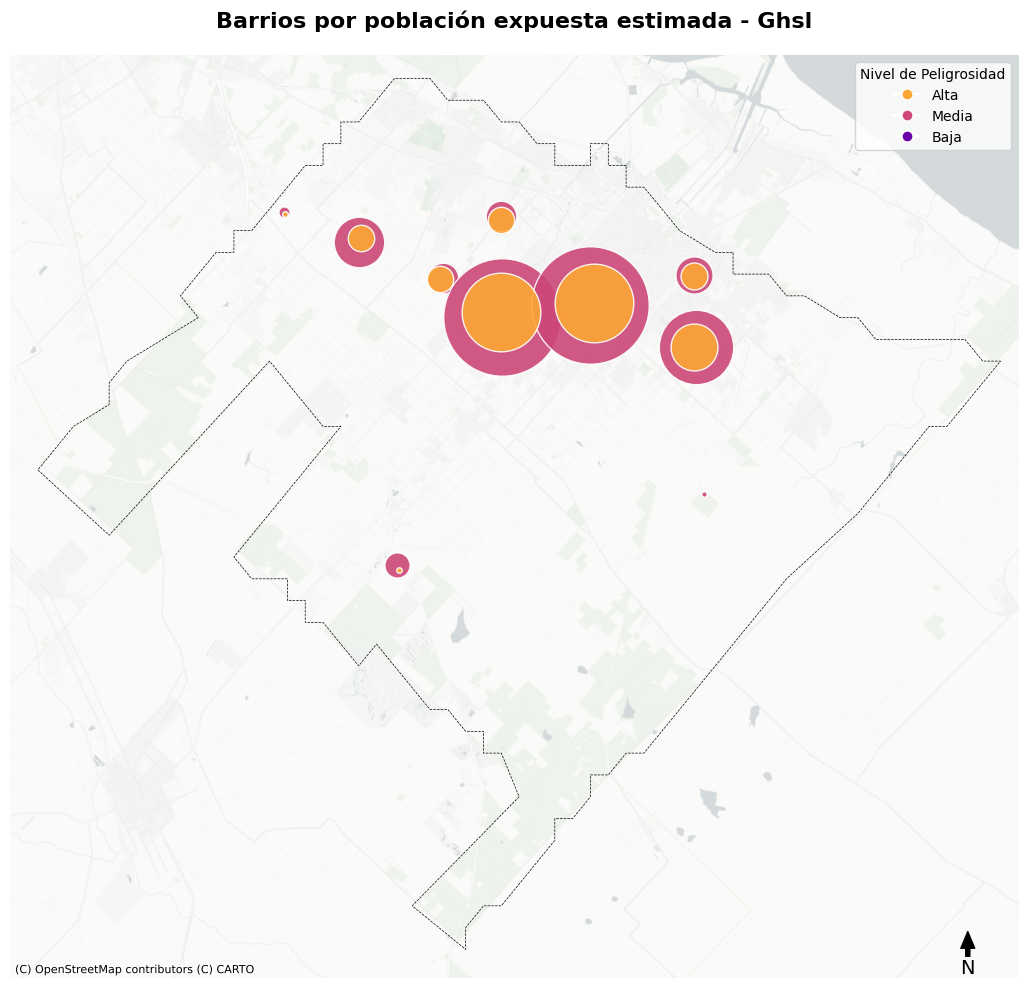

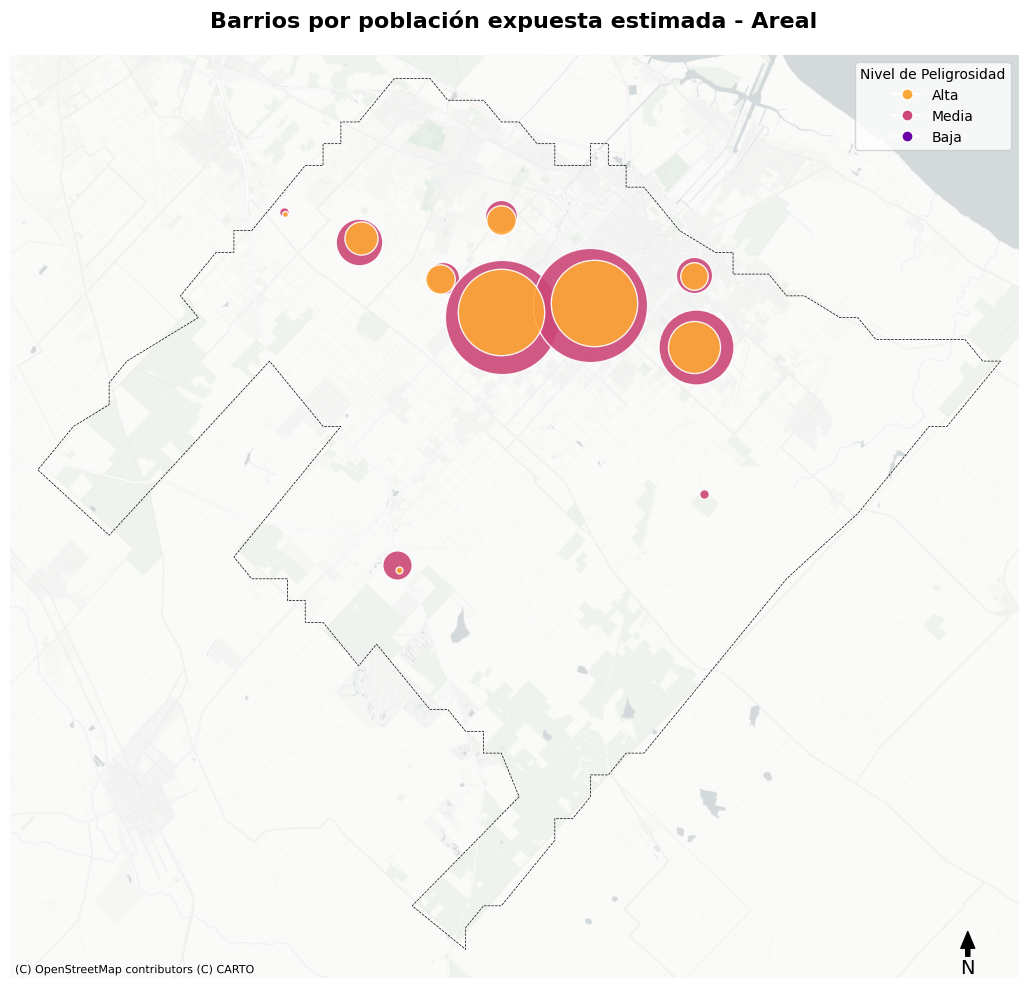

In [69]:
# Create centroid geodataframe from cuencas
cuencas_centroids = cuencas.copy()
cuencas_centroids['geometry'] = cuencas_centroids['geometry'].centroid

# Create a lowercase version of Cuenca for matching
cuencas_centroids['cuenca_lower'] = cuencas_centroids['Cuenca'].str.lower()

# Join cuenca_tidy with cuencas_centroids using the lowercase names
cuenca_tidy_with_geometry = cuenca_tidy.merge(
    cuencas_centroids[['cuenca_lower', 'geometry']], 
    left_on='cuenca', 
    right_on='cuenca_lower', 
    how='left'
)

# Convert to GeoDataFrame
cuenca_tidy_gdf = gpd.GeoDataFrame(cuenca_tidy_with_geometry, geometry='geometry', crs=cuencas.crs)

methods = cuenca_tidy_gdf["metodo"].unique()

for method in methods:
    plot_method_map(method, cuenca_tidy_gdf, la_plata, peligrosidad_colors, common_bounds, create_consistent_map)

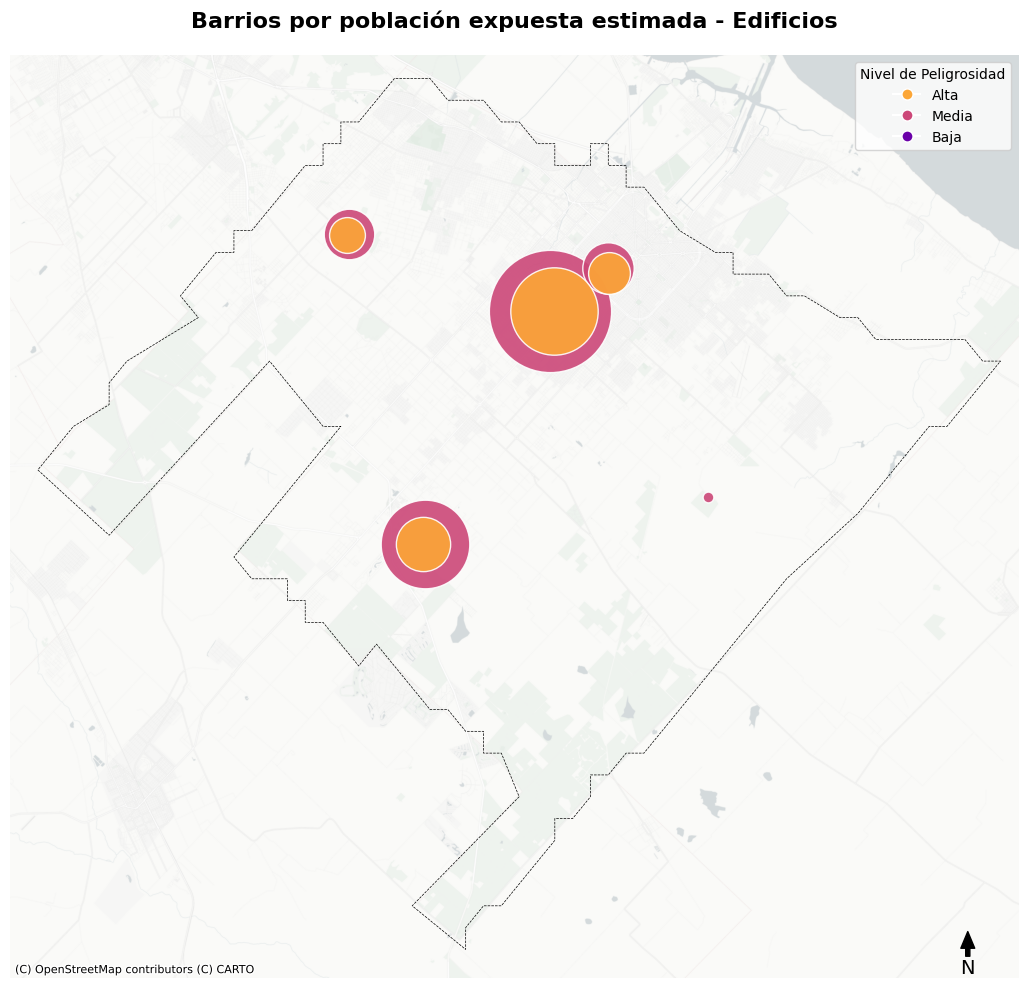

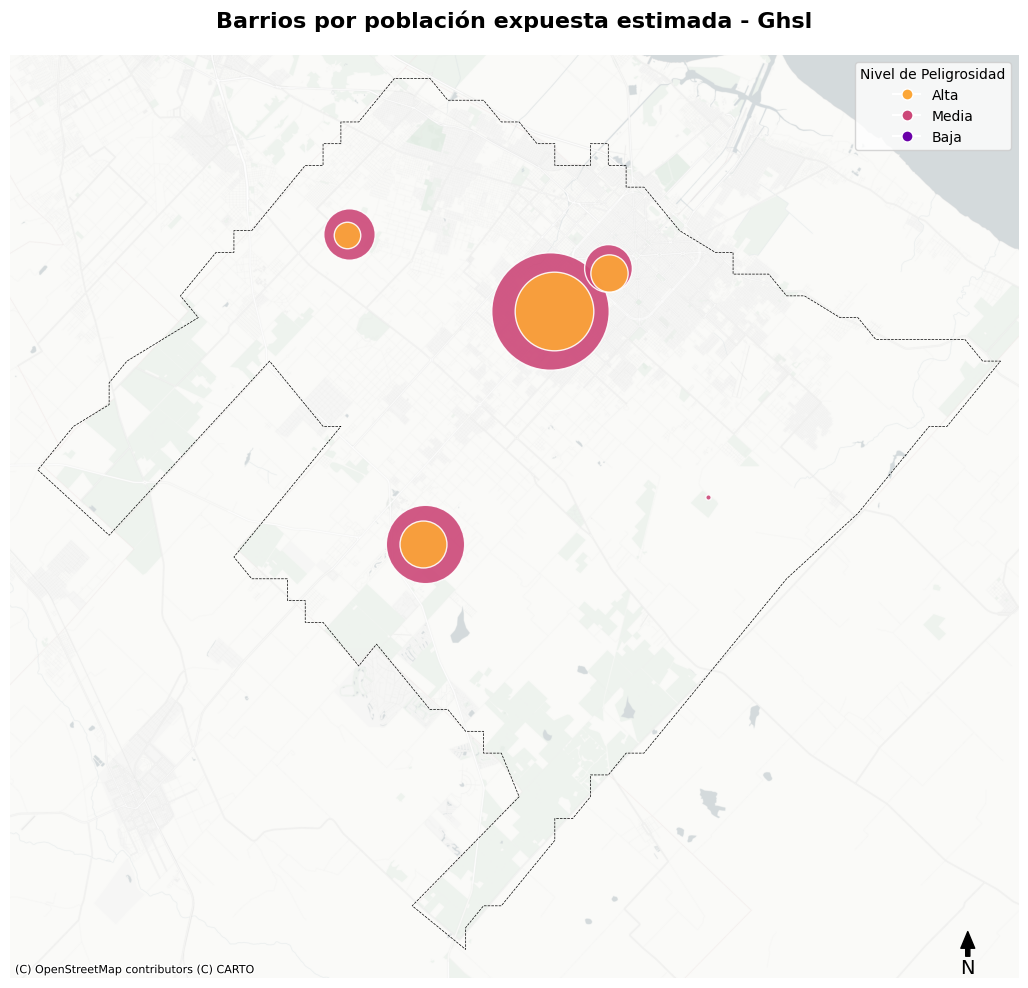

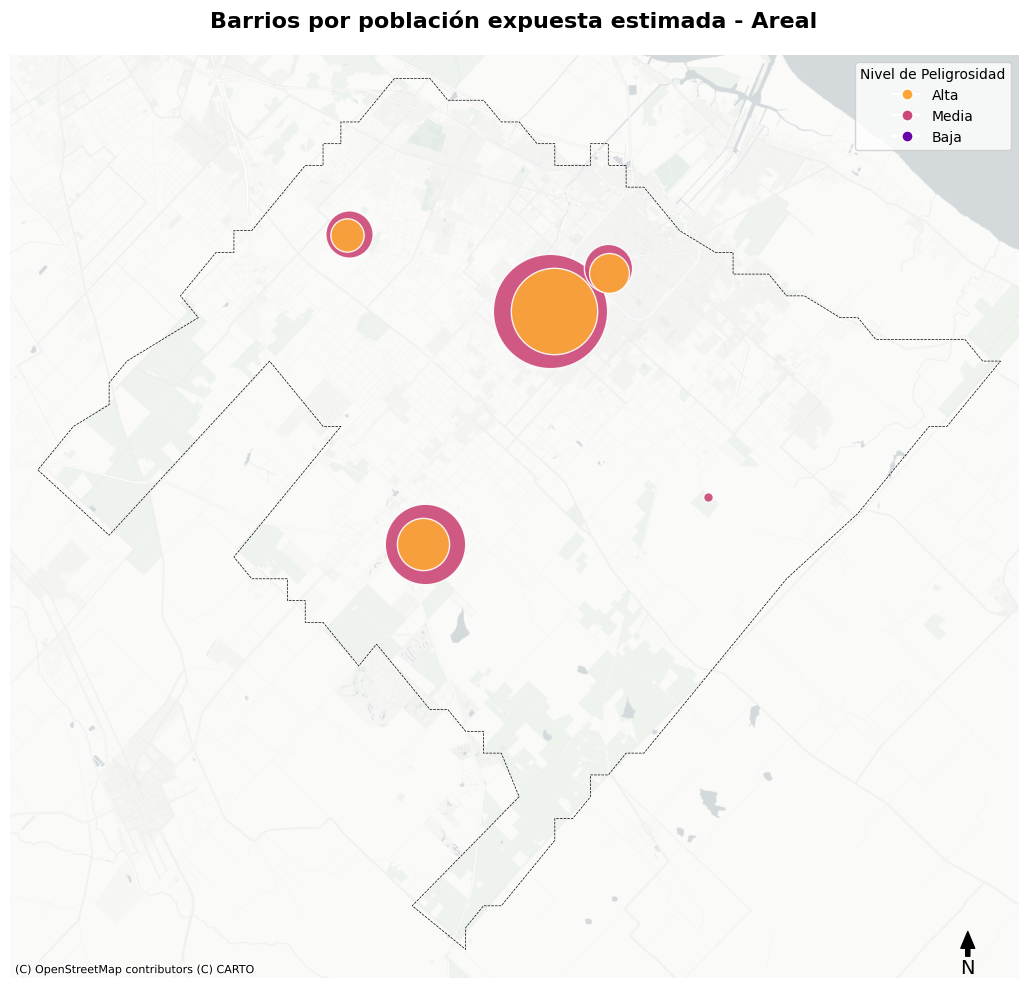

In [70]:
# Create eje_tidy by melting eje_wide
eje_tidy = pd.melt(
    eje_wide, 
    id_vars=['eje', 'peligrosidad'],
    value_vars=['fam_expuestas_edificios', 'fam_expuestas_ghsl', 'fam_expuestas_areal'],
    var_name='metodo',
    value_name='fam_expuestas'
)

# Clean up method names
eje_tidy['metodo'] = eje_tidy['metodo'].str.replace('fam_expuestas_', '')

# Create eje geodataframe by dissolving cuencas by eje and then taking centroids
ejes = cuencas.dissolve(by='eje').reset_index()
ejes_centroids = ejes.copy()
ejes_centroids['geometry'] = ejes_centroids['geometry'].centroid

# Join eje_tidy with ejes_centroids
eje_tidy_with_geometry = eje_tidy.merge(
    ejes_centroids[['eje', 'geometry']], 
    on='eje', 
    how='left'
)

# Convert to GeoDataFrame
eje_tidy_gdf = gpd.GeoDataFrame(eje_tidy_with_geometry, geometry='geometry', crs=cuencas.crs)

methods = eje_tidy_gdf["metodo"].unique()

for method in methods:
    plot_method_map(method, eje_tidy_gdf, la_plata, peligrosidad_colors, common_bounds, create_consistent_map)